# Visualisation 

In [1]:
import numpy as np
import os
import cv2 as cv2
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


In [2]:
def show(img, factor=1,name="image"):
    """ 
    show an image until the escape key is pressed
    :param factor: scale factor (default 1, half size)
    """
    if factor != 1.0:
        img = cv2.resize(img, (0,0), fx=factor, fy=factor) 

    cv2.imshow(name,img)
    while(1):
        k = cv2.waitKey(0)
        if k==27:    # Esc key to stop
            break
    cv2.destroyAllWindows()

In [3]:
def read_image(input_path):
    img = cv2.imread(input_path,0)
    return img

In [4]:
def get_pixel(img, center, x, y): 
      
    new_value = 0
      
    try: 
        # If local neighbourhood pixel  
        # value is greater than or equal 
        # to center pixel values then  
        # set it to 1 
        if img[x][y] >= center: 
            new_value = 1
              
    except: 
        # Exception is required when  
        # neighbourhood value of a center 
        # pixel value is null i.e. values 
        # present at boundaries. 
        pass
      
    return new_value 
   
# Function for calculating LBP 
def lbp_calculated_pixel(img, x, y): 
   
    center = img[x][y] 
   
    val_ar = [] 
      
    # top_left 
    val_ar.append(get_pixel(img, center, x-1, y-1)) 
      
    # top 
    val_ar.append(get_pixel(img, center, x-1, y)) 
      
    # top_right 
    val_ar.append(get_pixel(img, center, x-1, y + 1)) 
      
    # right 
    val_ar.append(get_pixel(img, center, x, y + 1)) 
      
    # bottom_right 
    val_ar.append(get_pixel(img, center, x + 1, y + 1)) 
      
    # bottom 
    val_ar.append(get_pixel(img, center, x + 1, y)) 
      
    # bottom_left 
    val_ar.append(get_pixel(img, center, x + 1, y-1)) 
      
    # left 
    val_ar.append(get_pixel(img, center, x, y-1)) 
       
    # Now, we need to convert binary 
    # values to decimal 
    power_val = [1, 2, 4, 8, 16, 32, 64, 128] 
   
    val = 0
      
    for i in range(len(val_ar)): 
        val += val_ar[i] * power_val[i] 
          
    return val 
   

def get_LBP(sentence,show_steps=1,show_size=0.2):

    height, width = sentence.shape 


    # Create a numpy array as  
    # the same height and width  
    # of RGB image 
    img_lbp = np.zeros((height, width), np.uint8) 

    for i in range(0, height): 
        for j in range(0, width): 
            img_lbp[i, j] = lbp_calculated_pixel(sentence, i, j) 
    return img_lbp
#img = get_LBP(sentences[0])
#show(img)

## Dividing Paper

In [5]:
def preprocess_img(img,show_steps=1,show_size=0.2):
    img = cv2.GaussianBlur(img,(11,11),0)
    thresh = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img[img >= thresh[0]] = 255
    img[img <= thresh[0]] = 0
    img = cv2.bitwise_not(img)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(2,2))
    img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
    if show_steps == 1:        
        show(img,show_size,"Preprocessed Image")
    return img

In [6]:
def remove_top(img,show_steps=1,show_size=0.2):
    trsh = 0.1
    kernel = np.ones((5,5),np.uint8)
    erosion = cv2.dilate(img,kernel,iterations = 8)
    proj = np.sum(erosion,axis=1).astype(int)
    if show_steps == 1:        
        show(erosion,show_size,"Eroded")
    max_line = np.amax(proj)



    lines = []
    lines.append(300)
    for i in range(img.shape[0]):
        if(proj[i] >= trsh*max_line) :
            if(len(lines) > 0 ):
                if(lines[-1] + img.shape[0]/10 > i ):
                    continue
            if( (i>=500 and i <= 900) or (i>=2600 and i <= 2900)):
                lines.append(i)
    if show_steps == 1:        
        show(img[lines[1]:lines[2],:],show_size,"Cropped Image")
    
    return img[lines[1]:lines[2],:]


In [7]:
def get_sentences(img,show_steps=1,show_size=0.2):
    
    original = img.copy()
    blurred = cv2.GaussianBlur(img, (1, 1), 0)
    canny = cv2.Canny(blurred, 50, 255, 1)
    kernel = np.ones((1,5),np.uint8)
    dilate = cv2.dilate(canny, kernel, iterations=40)
    
    if show_steps == 1:        
        show(dilate,show_size,"Sentences")
    
    # Find contours
    cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    # Iterate thorugh contours and filter for ROI
    image_number = 0
    order_list = []
    images = []
    area = 0 
    for c in cnts:
        area += cv2.contourArea(c)
    area /= (len(cnts)+5)
    for c in cnts:
        if(cv2.contourArea(c) > area):
            x,y,w,h = cv2.boundingRect(c)
            if h > img.shape[0]/8:
                continue
            #cv2.rectangle(img, (x, y), (x + w, y + h), (36,255,12), 2)
            ROI = original[y:y+h, x:x+w]
            if show_steps == 1:        
                show(ROI,show_size,"Sentence")
            images.append(ROI)
            order_list.append(y+x/1000)
            image_number += 1
    segments = [x for _,x in sorted(zip(order_list,images))]
    return segments

In [8]:
def crop_img(img):
    mask_inv = img
    ver_sum = np.sum(mask_inv,axis=1)
    v_start = 0
    v_end = 0
    for i in range(len(ver_sum)):
        if(ver_sum[i] > 0 and v_start ==0):
            v_start = i
        if(ver_sum[i] == 0 and v_start != 0):
            v_end = i
            break
    if(v_end == 0):
        v_end = len(ver_sum) - 1
    
    hor_sum = np.sum(mask_inv,axis=0)
    h_start = 0
    h_end = 0
    for i in range(len(hor_sum)):
        if(hor_sum[i] > 0 and h_start ==0):
            h_start = i
        if(hor_sum[i] == 0 and h_start != 0):
            h_end = i
            break
    if(h_end == 0):
        h_end = len(hor_sum) - 1

    return img[v_start:v_end,h_start:h_end]

In [9]:
def get_horizontal_merge(sentence,show_steps=1,show_size=0.2):
    original = np.copy(sentence)
    
    # Find contours
    cnts = cv2.findContours(sentence, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    # Iterate thorugh contours and filter for ROI
    order_list = []
    images = []
    area = 0 
    for c in cnts:
        area += cv2.contourArea(c)
    area /= len(cnts)
    for c in cnts:
        if(cv2.contourArea(c) > area/10):
            x,y,w,h = cv2.boundingRect(c)
            ROI = original[:,x:x+w]
            images.append(ROI)
            order_list.append(x)

    hori_merged = np.zeros((original.shape[0],original.shape[1]))
    segments = [sorter for _,sorter in sorted(zip(order_list,images))]
    current = 0
    for segment in segments:
        hori_merged[:,current:current+segment.shape[1]] = segment
        current = current+segment.shape[1]
    hori_merged = crop_img(hori_merged)
    return hori_merged

In [15]:
def rearrange_image(image):
    copy = np.zeros((image.shape[0], image.shape[1]))
    #print("Image shape is ", image.shape, ", copy shape is ", copy.shape)
    sentences = get_sentences(image,0)
    contours, hierarchy = cv2.findContours(image.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    avg_height = 0
    l = len(contours)
    for contour in contours:
        x,y,w,h = cv2.boundingRect(contour)
        avg_height += h
    avg_height = int(avg_height/l)
    currentY = 0
    for i, sentence in enumerate(sentences):
        #print(currentY)
        sentence = get_horizontal_merge(sentence,0)
        copy[currentY:currentY+sentence.shape[0],0:sentence.shape[1]] += sentence
        #print("Copy after ", i, " sentence(s)")
        #show(copy, 0.2, "copy")
        currentY += int(avg_height/2)
        
    return copy[:currentY+ int(avg_height),:]
        

In [16]:
def divide_image(image):
    factor = 3
    height, width = image.shape
    img_arr = []
    w_3 =int(width/3)
    h_3= int(height/3)
    #first row
    img_arr.append(image[0:h_3 , 0:w_3])
    img_arr.append(image[0:h_3 , w_3:2*w_3])
    img_arr.append(image[0:h_3 , 2*w_3:3*w_3])
    
    #second row
    img_arr.append(image[h_3:2*h_3 , 0:w_3])
    img_arr.append(image[h_3:2*h_3 , w_3:2*w_3])
    img_arr.append(image[h_3:2*h_3 , 2*w_3:3*w_3])
    
    #third row
    img_arr.append(image[2*h_3:3*h_3 , 0:w_3])
    img_arr.append(image[2*h_3:3*h_3 , w_3:2*w_3])
    img_arr.append(image[2*h_3:3*h_3 , 2*w_3:3*w_3])
    
    return img_arr

# Main

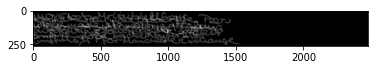

In [18]:
input_path = '/home/ahmad/Desktop/AlexRun/Pattern Recognition/Dataset/formsA-D/a01-000u.png'
show_steps = 0
show_size = 0.2

images = []
#for file in os.listdir(input_path):
#    images.append(file)
#images.sort()
#for input_img in images:   
#show(im)
img = read_image(input_path)#+input_img)
img = preprocess_img(img,show_steps,show_size)
img = remove_top(img,show_steps,show_size)

# kernel = np.ones((5,5))
# dilation = cv2.dilate(img,kernel,iterations = 20)
sentences = get_sentences(img,show_steps,show_size)
# show(dilation, 0.2, "Dilated")
# cropped = cropImage(dilation)
# show(cropped, 0.2, "Cropped")
rearranged = rearrange_image(img)
#show(rearranged, 0.5, "Rearranged")
imgplot = plt.imshow(rearranged, cmap='gray')
plt.show()
img_arr = divide_image(rearranged)
for img in img_arr:
    show(img, 0.5)


In [ ]:
# this is for testing the read data code
for i in images:
    for img in i:
        show(img, 0.5)
    print("finished folder")      

In [ ]:
def training_data(folder_name):
    input_path = "/media/madmax/MadMax_D/CUFE/Fall_2021/CMPN450_PatternRecognition_and_NeuralNetworks/Project document/Writer-Recognition/data/" + folder_name + "/"
    images = []
    labeles=[]
    # iterate over all 3 writers and add their feature vectors
    for i in range(1, 4):
        newpath = input_path + str(i) + "/"
        for file in os.listdir(newpath):
            images.append(cv2.imread(newpath + file))
            labeles.append(i)
#     print(len(images))
#     print(len(labeles))

    return images, labeles

In [ ]:
#show(original, 0.5)

In [ ]:
test_cases_count=10
images = []
lables=[]
for test_cases in range (1,test_cases_count + 1):
    folder_name = str(test_cases)
    while len(folder_name)<2:
        folder_name = "0" + folder_name
    images_temp,lables_temp = training_data(folder_name)
    images.append(images_temp)
    lables.append(lables_temp)